# Sweep Analysis Notebook

This notebook provides comprehensive analysis and visualization of hyperparameter sweep results from WandB.

## Features:
- Summary statistics of sweep parameters and metrics
- Cost vs Score scatter plot with level sets
- Time vs Score plot
- Time vs Cost plot
- Parameter correlation matrix
- Parameter importance analysis


In [25]:
# Settings Cell - Configure your sweep analysis here

# WandB Configuration
WANDB_ENTITY = "metta-research"  # Replace with your WandB entity
WANDB_PROJECT = "metta"  # Replace with your WandB project
WANDB_SWEEP_NAME = "axel.sky_sweep.v2"  # Replace with your sweep ID
WANDB_SWEEP_ID = None
SWEEP_SERVER_URI = "https://api.observatory.softmax-research.net"
# Analysis Configuration
MAX_OBSERVATIONS = 1000  # Maximum number of observations to load
TOP_K_PARAMETERS = 15  # Number of top parameters to show in importance plot
FIGURE_SIZE = (10, 8)  # Default figure size for plots
COLOR_PALETTE = "viridis"  # Color palette for visualizations


In [26]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde
from typing import Dict, List, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Add the metta module to path if running from notebooks directory
sys.path.append(os.path.abspath('..'))

# Import sweep utilities
from metta.sweep.wandb_utils import fetch_protein_observations_from_wandb
from cogweb.cogweb_client import CogwebClient
import wandb

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette(COLOR_PALETTE)


In [27]:
# Helper functions for data processing

def flatten_nested_dict(d: Dict[str, Any], parent_key: str = '', sep: str = '.') -> Dict[str, Any]:
    """Flatten a nested dictionary structure."""
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_nested_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def extract_observations_to_dataframe(observations: List[Dict[str, Any]]) -> pd.DataFrame:
    """Convert protein observations to a pandas DataFrame."""
    data_rows = []
    
    for obs in observations:
        if obs.get('is_failure', False):
            continue
            
        suggestion = obs.get('suggestion', {})
        flat_params = flatten_nested_dict(suggestion)
        
        # Add metrics
        flat_params['score'] = obs.get('objective', np.nan)
        flat_params['cost'] = obs.get('cost', np.nan)
        flat_params['runtime'] = obs.get('cost', np.nan)  # Cost is actually runtime in seconds
        flat_params['timestamp'] = obs.get('timestamp', obs.get('created_at', np.nan))  # Creation timestamp
        
        data_rows.append(flat_params)
    
    # Convert to DataFrame and ensure timestamp is datetime
    df = pd.DataFrame(data_rows)
    if 'timestamp' in df.columns and not df['timestamp'].isna().all():
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        # Sort by timestamp to ensure chronological order
        df = df.sort_values('timestamp').reset_index(drop=True)
    
    return df


In [28]:
# Load sweep data
print(f"Loading sweep data from WandB...")
print(f"Entity: {WANDB_ENTITY}")
print(f"Project: {WANDB_PROJECT}")
print(f"Sweep Name: {WANDB_SWEEP_NAME}")

# Get sweep ID if not provided
if WANDB_SWEEP_ID is None:
    cogweb_client = CogwebClient.get_client(base_url=SWEEP_SERVER_URI)
    sweep_client = cogweb_client.sweep_client()
    WANDB_SWEEP_ID = sweep_client.get_sweep(WANDB_SWEEP_NAME).wandb_sweep_id
    print(f"Retrieved Sweep ID: {WANDB_SWEEP_ID}")

# Fetch observations
observations = fetch_protein_observations_from_wandb(
    wandb_entity=WANDB_ENTITY,
    wandb_project=WANDB_PROJECT,
    wandb_sweep_id=WANDB_SWEEP_ID,
    max_observations=MAX_OBSERVATIONS
)

print(f"\nLoaded {len(observations)} observations")

# Enhance observations with timestamps by fetching run metadata
print("Fetching timestamps from WandB runs...")
api = wandb.Api()
wandb_path = f"{WANDB_ENTITY}/{WANDB_PROJECT}"

# Create a mapping of observations to timestamps
enhanced_observations = []
runs = api.runs(
    path=wandb_path,
    filters={
        "sweep": WANDB_SWEEP_ID,
        "state": {"$in": ["finished", "failed"]},
        "summary_metrics.protein_observation": {"$exists": True},
    },
    order="-created_at",
    per_page=MAX_OBSERVATIONS,
)

for run in runs:
    obs = run.summary.get("protein_observation")
    if obs:
        obs_copy = dict(obs)
        obs_copy['timestamp'] = run.created_at
        obs_copy['run_name'] = run.name
        obs_copy['run_id'] = run.id
        enhanced_observations.append(obs_copy)

print(f"Enhanced {len(enhanced_observations)} observations with timestamps")

# Convert to DataFrame
df = extract_observations_to_dataframe(enhanced_observations)
print(f"Valid observations after filtering: {len(df)}")


Loading sweep data from WandB...
Entity: metta-research
Project: metta
Sweep Name: axel.sky_sweep.v2
Retrieved Sweep ID: lnjzuler

Loaded 89 observations
Fetching timestamps from WandB runs...
Enhanced 89 observations with timestamps
Valid observations after filtering: 89


## 1. Sweep Summary Statistics


In [29]:
# Calculate summary statistics
if not df.empty:
    # Identify parameter columns (exclude metrics)
    metric_cols = ['score', 'cost', 'time']
    param_cols = [col for col in df.columns if col not in metric_cols]
    
    # Get unique parameter values
    param_summary = {}
    for col in param_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            param_summary[col] = {
                'type': 'numeric',
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'std': df[col].std(),
                'unique_values': df[col].nunique()
            }
        else:
            param_summary[col] = {
                'type': 'categorical',
                'unique_values': df[col].nunique(),
                'values': df[col].unique().tolist()[:10]  # Show first 10 unique values
            }
    
    # Display sweep summary
    print("=" * 80)
    print("SWEEP SUMMARY")
    print("=" * 80)
    
    print(f"\nTotal Runs: {len(df)}")
    print(f"Successful Runs: {len(df[df['score'].notna()])}")
    print(f"Failed Runs: {len(observations) - len(df)}")
    
    print(f"\nMetrics Summary:")
    print(f"  Average Score: {df['score'].mean():.4f} (±{df['score'].std():.4f})")
    print(f"  Best Score: {df['score'].max():.4f}")
    print(f"  Worst Score: {df['score'].min():.4f}")
    
    print(f"\n  Average Run Time: {df['runtime'].mean():.2f} seconds")
    print(f"  Total Run Time: {df['runtime'].sum():.2f} seconds ({df['runtime'].sum()/3600:.2f} hours)")
    
    if 'timestamp' in df.columns and not df['timestamp'].isna().all():
        print(f"\n  First Run: {df['timestamp'].min()}")
        print(f"  Last Run: {df['timestamp'].max()}")
        print(f"  Sweep Duration: {df['timestamp'].max() - df['timestamp'].min()}")
    
    print(f"\n  Average Cost: {df['cost'].mean():.2f}")
    print(f"  Total Cost: {df['cost'].sum():.2f}")
    
    print(f"\nParameters Being Swept ({len(param_cols)} total):")
    for i, (param, info) in enumerate(param_summary.items()):
        if i < 10:  # Show first 10 parameters
            if info['type'] == 'numeric':
                print(f"  - {param}: {info['min']:.4f} to {info['max']:.4f} ({info['unique_values']} unique values)")
            else:
                print(f"  - {param}: {info['unique_values']} unique values")
    
    if len(param_cols) > 10:
        print(f"  ... and {len(param_cols) - 10} more parameters")
else:
    print("No valid observations found in the sweep data.")


SWEEP SUMMARY

Total Runs: 89
Successful Runs: 89
Failed Runs: 0

Metrics Summary:
  Average Score: 0.0087 (±0.0075)
  Best Score: 0.0396
  Worst Score: 0.0000

  Average Run Time: 101.11 seconds
  Total Run Time: 8998.58 seconds (2.50 hours)

  First Run: 2025-07-25 19:19:02+00:00
  Last Run: 2025-07-26 00:24:30+00:00
  Sweep Duration: 0 days 05:05:28

  Average Cost: 101.11
  Total Cost: 8998.58

Parameters Being Swept (3 total):
  - trainer: 89 unique values
  - runtime: 86.0906 to 109.6784 (89 unique values)
  - timestamp: 89 unique values


## 2. Cost vs Score Scatter Plot with Level Sets


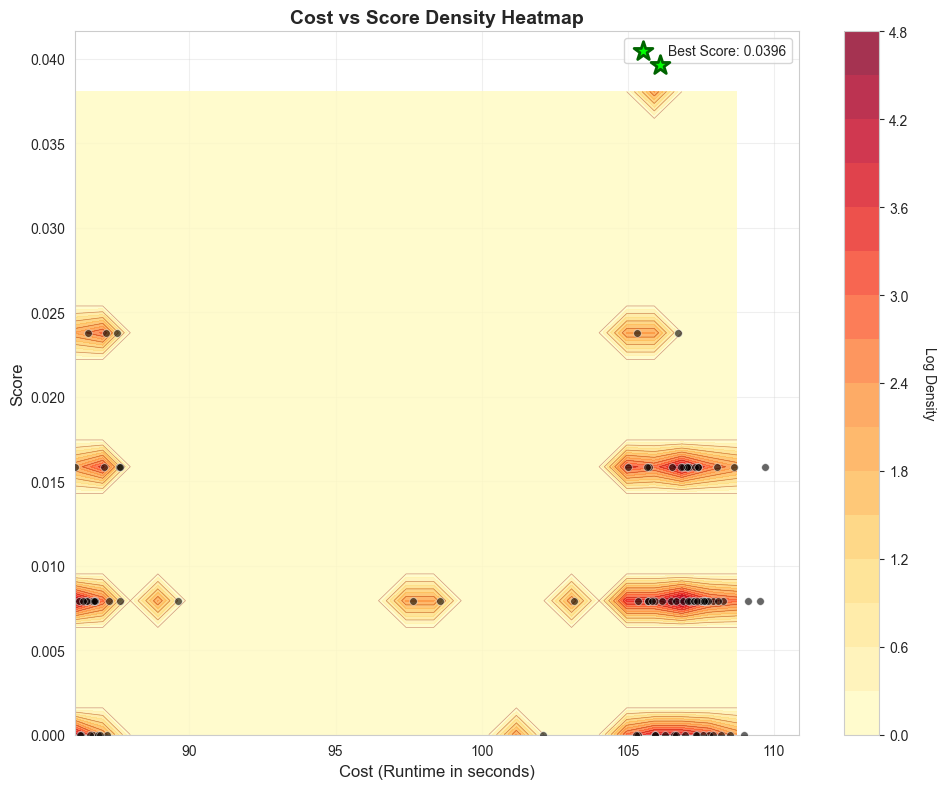

In [30]:
if not df.empty and 'cost' in df.columns and 'score' in df.columns:
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    # Remove any NaN values
    plot_df = df[['cost', 'score']].dropna()
    
    if len(plot_df) > 0:
        # Create 2D histogram heatmap
        if len(plot_df) > 5:
            try:
                # Calculate 2D histogram
                hist, xedges, yedges = np.histogram2d(
                    plot_df['cost'], 
                    plot_df['score'], 
                    bins=25,
                    density=True
                )
                
                # Create meshgrid for plotting
                X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
                
                # Plot as heatmap with filled contours
                # Use log scale for better visibility of low-density areas
                hist_log = np.log1p(hist.T)  # Transpose for correct orientation
                
                # Create filled contour plot
                contourf = ax.contourf(X, Y, hist_log, levels=15, cmap='YlOrRd', alpha=0.8)
                
                # Add contour lines for clarity
                contour = ax.contour(X, Y, hist_log, levels=8, colors='darkred', 
                                   alpha=0.4, linewidths=0.5)
                
                # Add colorbar
                cbar = plt.colorbar(contourf, ax=ax)
                cbar.set_label('Log Density', rotation=270, labelpad=20)
                
                # Overlay scatter points
                scatter = ax.scatter(plot_df['cost'], plot_df['score'], 
                                   alpha=0.6, s=30, c='black', edgecolors='white', 
                                   linewidth=0.5, zorder=10)
                
            except Exception as e:
                print(f"Could not generate density heatmap: {e}")
                # Fallback to simple scatter
                ax.scatter(plot_df['cost'], plot_df['score'], 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        else:
            # Not enough points for density estimation
            ax.scatter(plot_df['cost'], plot_df['score'], 
                      alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # Highlight best point
        best_idx = plot_df['score'].idxmax()
        ax.scatter(float(plot_df.loc[best_idx, 'cost']), 
                  float(plot_df.loc[best_idx, 'score']),
                  color='lime', s=200, marker='*', 
                  edgecolors='darkgreen', linewidth=2,
                  label=f'Best Score: {plot_df.loc[best_idx, "score"]:.4f}',
                  zorder=20)
        
        ax.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Cost vs Score Density Heatmap', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, zorder=0)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid cost/score data to plot")
else:
    print("Missing cost or score data")


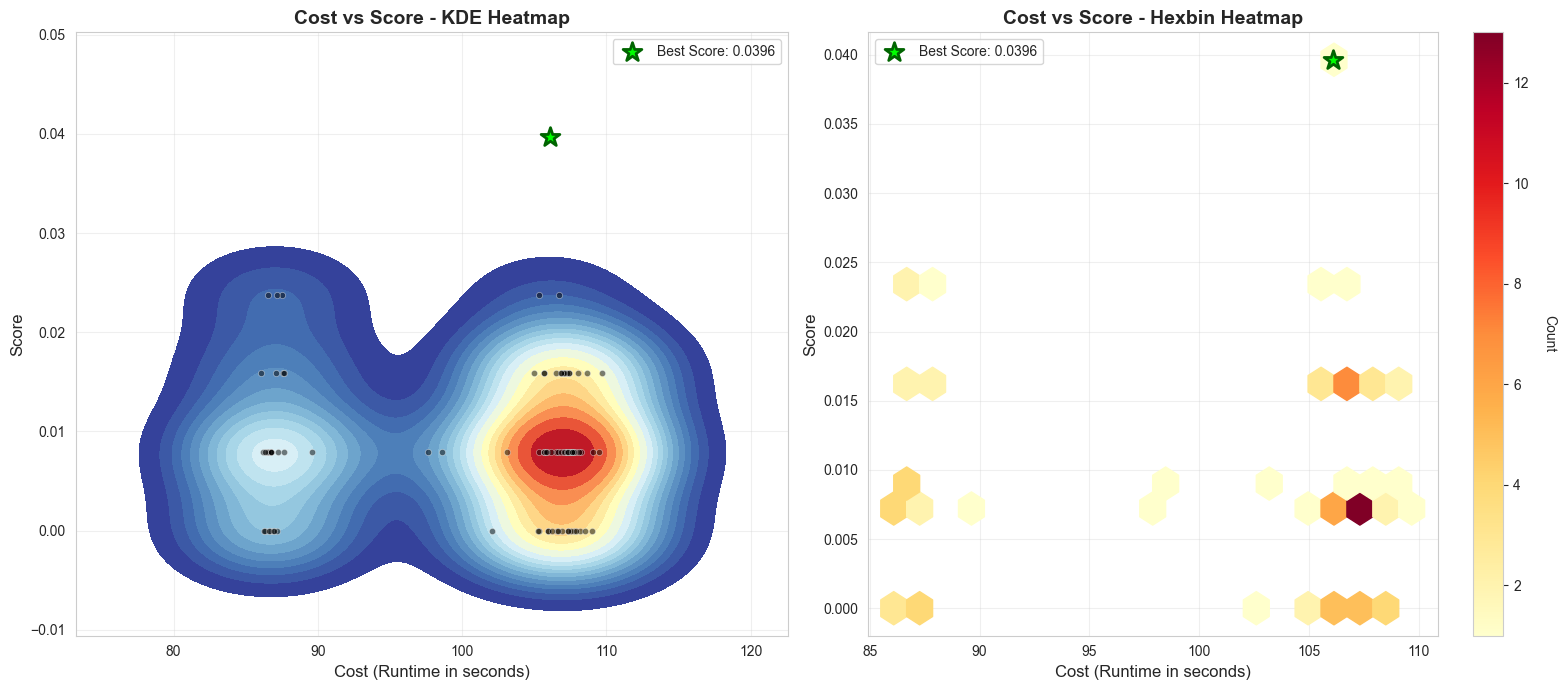

In [31]:
# Alternative: Cost vs Score using Seaborn KDE (Kernel Density Estimation)
if not df.empty and 'cost' in df.columns and 'score' in df.columns:
    plot_df = df[['cost', 'score']].dropna()
    
    if len(plot_df) > 5:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        
        # Left plot: KDE Heatmap
        try:
            # Create KDE plot with filled contours
            sns.kdeplot(
                data=plot_df,
                x='cost',
                y='score',
                fill=True,
                cmap='RdYlBu_r',
                levels=20,
                thresh=0.05,
                ax=ax1
            )
            
            # Overlay scatter points
            ax1.scatter(plot_df['cost'], plot_df['score'], 
                       alpha=0.5, s=20, c='black', edgecolors='white', 
                       linewidth=0.5, zorder=10)
            
            # Highlight best point
            best_idx = plot_df['score'].idxmax()
            ax1.scatter(plot_df.loc[best_idx, 'cost'], 
                       plot_df.loc[best_idx, 'score'],
                       color='lime', s=200, marker='*', 
                       edgecolors='darkgreen', linewidth=2,
                       label=f'Best Score: {plot_df.loc[best_idx, "score"]:.4f}',
                       zorder=20)
            
            ax1.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
            ax1.set_ylabel('Score', fontsize=12)
            ax1.set_title('Cost vs Score - KDE Heatmap', fontsize=14, fontweight='bold')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
        except Exception as e:
            print(f"KDE plot failed: {e}")
            ax1.text(0.5, 0.5, 'KDE plot failed\nNot enough data points', 
                    ha='center', va='center', transform=ax1.transAxes)
        
        # Right plot: Hexbin Heatmap
        try:
            # Create hexbin plot
            hexbin = ax2.hexbin(plot_df['cost'], plot_df['score'], 
                               gridsize=20, cmap='YlOrRd', mincnt=1)
            
            # Add colorbar
            cb = plt.colorbar(hexbin, ax=ax2)
            cb.set_label('Count', rotation=270, labelpad=20)
            
            # Highlight best point
            ax2.scatter(plot_df.loc[best_idx, 'cost'], 
                       plot_df.loc[best_idx, 'score'],
                       color='lime', s=200, marker='*', 
                       edgecolors='darkgreen', linewidth=2,
                       label=f'Best Score: {plot_df.loc[best_idx, "score"]:.4f}',
                       zorder=20)
            
            ax2.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
            ax2.set_ylabel('Score', fontsize=12)
            ax2.set_title('Cost vs Score - Hexbin Heatmap', fontsize=14, fontweight='bold')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
        except Exception as e:
            print(f"Hexbin plot failed: {e}")
            
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for density visualization")


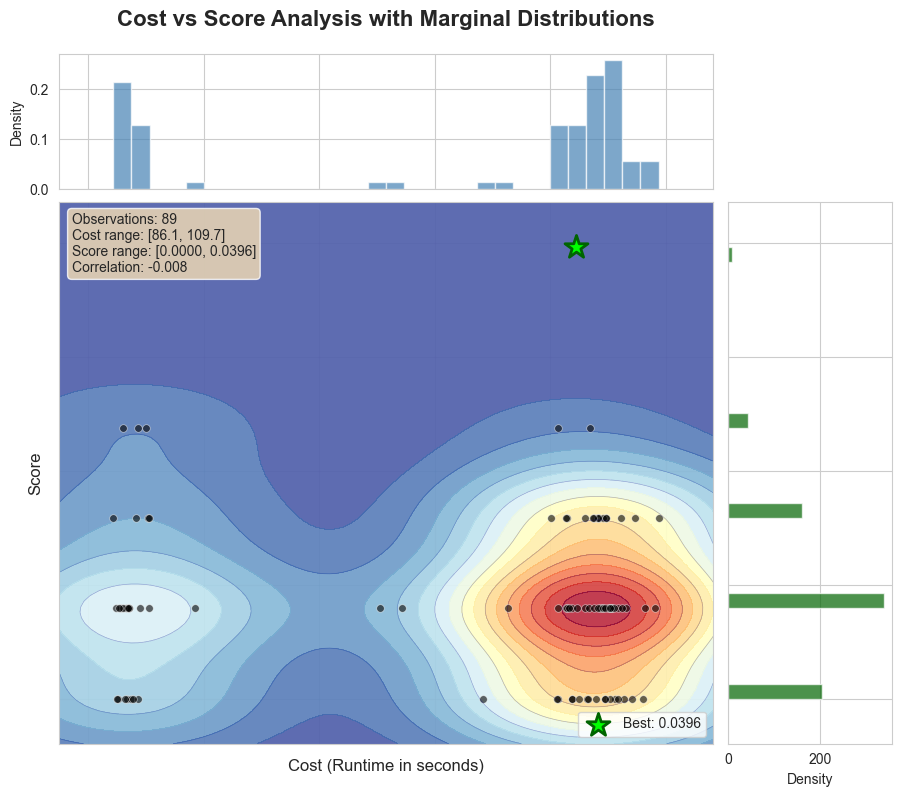

In [32]:
# Advanced visualization with marginal distributions
if not df.empty and 'cost' in df.columns and 'score' in df.columns:
    plot_df = df[['cost', 'score']].dropna()
    
    if len(plot_df) > 5:
        # Create figure with GridSpec for complex layout
        fig = plt.figure(figsize=(12, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05, 
                             height_ratios=[1, 4, 0.5], 
                             width_ratios=[4, 1, 0.5])
        
        # Main plot - 2D density heatmap
        ax_main = fig.add_subplot(gs[1, 0])
        
        # Top marginal - cost distribution
        ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
        
        # Right marginal - score distribution  
        ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
        
        # Main heatmap using gaussian KDE
        try:
            # Calculate 2D KDE
            from scipy.stats import gaussian_kde
            
            # Create grid for evaluation
            x_min, x_max = plot_df['cost'].min(), plot_df['cost'].max()
            y_min, y_max = plot_df['score'].min(), plot_df['score'].max()
            
            # Add padding
            x_range = x_max - x_min
            y_range = y_max - y_min
            x_min -= 0.1 * x_range
            x_max += 0.1 * x_range
            y_min -= 0.1 * y_range
            y_max += 0.1 * y_range
            
            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([plot_df['cost'], plot_df['score']])
            kernel = gaussian_kde(values)
            f = np.reshape(kernel(positions).T, xx.shape)
            
            # Plot filled contours
            contourf = ax_main.contourf(xx, yy, f, levels=20, cmap='RdYlBu_r', alpha=0.8)
            
            # Add contour lines
            contour = ax_main.contour(xx, yy, f, levels=10, colors='darkblue', 
                                     alpha=0.3, linewidths=0.5)
            
            # Overlay actual data points
            scatter = ax_main.scatter(plot_df['cost'], plot_df['score'], 
                                     s=30, alpha=0.6, c='black', 
                                     edgecolors='white', linewidth=0.5)
            
            # Highlight best point
            best_idx = plot_df['score'].idxmax()
            ax_main.scatter(plot_df.loc[best_idx, 'cost'], 
                           plot_df.loc[best_idx, 'score'],
                           color='lime', s=300, marker='*', 
                           edgecolors='darkgreen', linewidth=2,
                           label=f'Best: {plot_df.loc[best_idx, "score"]:.4f}',
                           zorder=100)
            
        except Exception as e:
            print(f"KDE calculation failed: {e}")
            # Fallback to simple scatter
            ax_main.scatter(plot_df['cost'], plot_df['score'], alpha=0.6)
        
        # Top marginal plot - cost distribution
        ax_top.hist(plot_df['cost'], bins=30, alpha=0.7, color='steelblue', density=True)
        ax_top.set_ylabel('Density')
        ax_top.set_xticklabels([])
        ax_top.set_title('Cost vs Score Analysis with Marginal Distributions', 
                        fontsize=16, fontweight='bold', pad=20)
        
        # Right marginal plot - score distribution
        ax_right.hist(plot_df['score'], bins=30, alpha=0.7, color='darkgreen', 
                     density=True, orientation='horizontal')
        ax_right.set_xlabel('Density')
        ax_right.set_yticklabels([])
        
        # Main plot labels
        ax_main.set_xlabel('Cost (Runtime in seconds)', fontsize=12)
        ax_main.set_ylabel('Score', fontsize=12)
        ax_main.legend(loc='lower right')
        ax_main.grid(True, alpha=0.3)
        
        # Add statistics text box
        stats_text = f"Observations: {len(plot_df)}\n"
        stats_text += f"Cost range: [{plot_df['cost'].min():.1f}, {plot_df['cost'].max():.1f}]\n"
        stats_text += f"Score range: [{plot_df['score'].min():.4f}, {plot_df['score'].max():.4f}]\n"
        stats_text += f"Correlation: {plot_df['cost'].corr(plot_df['score']):.3f}"
        
        ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    verticalalignment='top', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data points for advanced visualization")


## 3. Score Progression Over Time


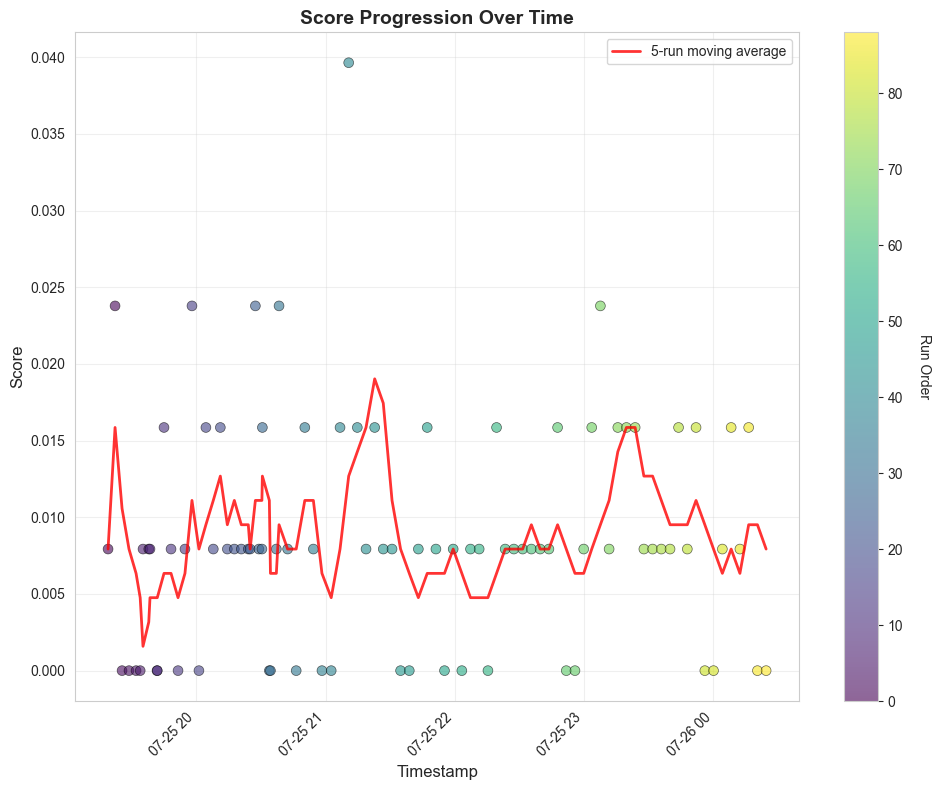

In [33]:
if not df.empty and 'timestamp' in df.columns and 'score' in df.columns:
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    # Remove NaN values
    plot_df = df[['timestamp', 'score']].dropna()
    
    if len(plot_df) > 0:
        # Create scatter plot showing progression over time
        scatter = ax.scatter(plot_df['timestamp'], plot_df['score'], 
                           alpha=0.6, s=50, c=range(len(plot_df)), 
                           cmap='viridis', edgecolors='black', linewidth=0.5)
        
        # Add a trend line
        ax.plot(plot_df['timestamp'], plot_df['score'].rolling(window=5, min_periods=1).mean(), 
                color='red', linewidth=2, alpha=0.8, label='5-run moving average')
        
        # Add colorbar to show progression
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Run Order', rotation=270, labelpad=20)
        
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Score Progression Over Time', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid timestamp/score data to plot")
else:
    print("Missing timestamp or score data")


## 4. Runtime Progression Over Time


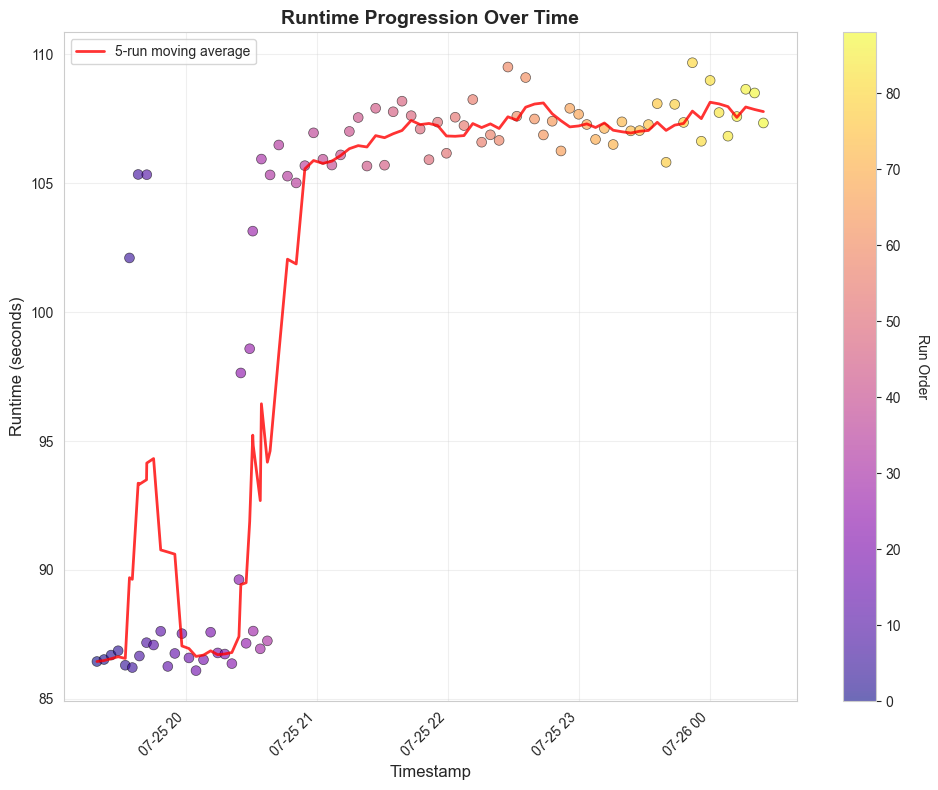

In [34]:
if not df.empty and 'timestamp' in df.columns and 'runtime' in df.columns:
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    
    # Remove NaN values
    plot_df = df[['timestamp', 'runtime']].dropna()
    
    if len(plot_df) > 0:
        # Create scatter plot showing runtime over time
        scatter = ax.scatter(plot_df['timestamp'], plot_df['runtime'], 
                           alpha=0.6, s=50, c=range(len(plot_df)), 
                           cmap='plasma', edgecolors='black', linewidth=0.5)
        
        # Add a trend line
        ax.plot(plot_df['timestamp'], plot_df['runtime'].rolling(window=5, min_periods=1).mean(), 
                color='red', linewidth=2, alpha=0.8, label='5-run moving average')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Run Order', rotation=270, labelpad=20)
        
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Runtime (seconds)', fontsize=12)
        ax.set_title('Runtime Progression Over Time', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid timestamp/runtime data to plot")
else:
    print("Missing timestamp or runtime data")


## 5. Parameter Correlation Matrix


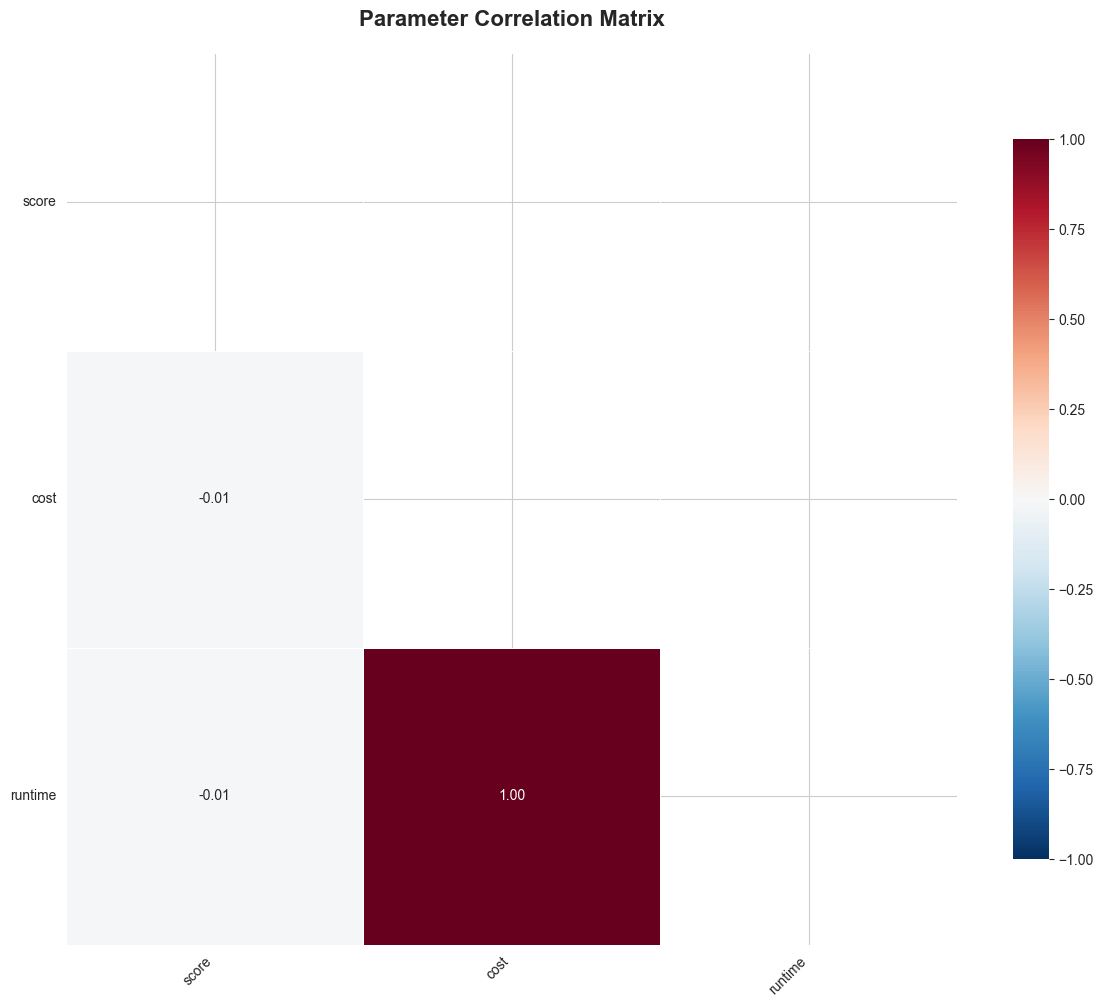

In [35]:
if not df.empty:
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Remove columns with too few unique values
    valid_columns = []
    for col in numeric_df.columns:
        if numeric_df[col].nunique() >= 2:
            valid_columns.append(col)
    
    if len(valid_columns) > 1:
        # Calculate correlation matrix
        corr_matrix = numeric_df[valid_columns].corr()
        
        # If we have too many parameters, focus on those most correlated with score
        if 'score' in corr_matrix.columns and len(corr_matrix) > 20:
            # Get top correlated parameters with score
            score_corr = corr_matrix['score'].abs().sort_values(ascending=False)
            top_params = score_corr.head(20).index.tolist()
            corr_matrix = corr_matrix.loc[top_params, top_params]
        
        # Create heatmap
        plt.figure(figsize=(12, 10))
        
        # Create mask for upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # Draw heatmap
        sns.heatmap(corr_matrix, 
                   mask=mask,
                   annot=True, 
                   fmt='.2f', 
                   cmap='RdBu_r',
                   vmin=-1, 
                   vmax=1, 
                   center=0,
                   square=True,
                   linewidths=0.5,
                   cbar_kws={"shrink": 0.8})
        
        plt.title('Parameter Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough numeric parameters for correlation analysis")
else:
    print("No data available for correlation analysis")


## 6. Parameter Importance Analysis


In [36]:
if not df.empty and 'score' in df.columns:
    # Select numeric columns excluding metrics
    metric_cols = ['score', 'cost', 'runtime', 'timestamp']
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    param_cols = [col for col in numeric_cols if col not in metric_cols]
    
    if len(param_cols) > 0:
        # Calculate correlations with score
        correlations = {}
        for col in param_cols:
            # Only include if we have enough unique values
            if df[col].nunique() >= 2:
                corr = df[col].corr(df['score'])
                if not np.isnan(corr):
                    correlations[col] = corr
        
        if correlations:
            # Sort by absolute correlation
            importance_df = pd.DataFrame([
                {'parameter': k, 'correlation': v, 'abs_correlation': abs(v)}
                for k, v in correlations.items()
            ]).sort_values('abs_correlation', ascending=False).head(TOP_K_PARAMETERS)
            
            # Create importance plot
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Create color map based on correlation direction
            colors = ['darkred' if x < 0 else 'darkblue' for x in importance_df['correlation']]
            
            # Create horizontal bar plot
            bars = ax.barh(importance_df['parameter'], 
                          importance_df['abs_correlation'],
                          color=colors, alpha=0.7)
            
            # Add correlation values as text
            for i, (idx, row) in enumerate(importance_df.iterrows()):
                ax.text(row['abs_correlation'] + 0.01, i, 
                       f"{row['correlation']:.3f}",
                       va='center', fontsize=9)
            
            ax.set_xlabel('Absolute Correlation with Score', fontsize=12)
            ax.set_ylabel('Parameter', fontsize=12)
            ax.set_title(f'Top {len(importance_df)} Most Important Parameters', 
                        fontsize=14, fontweight='bold')
            ax.set_xlim(0, 1.1)
            ax.grid(True, axis='x', alpha=0.3)
            
            # Add legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='darkblue', alpha=0.7, label='Positive correlation'),
                Patch(facecolor='darkred', alpha=0.7, label='Negative correlation')
            ]
            ax.legend(handles=legend_elements, loc='lower right')
            
            plt.tight_layout()
            plt.show()
            
            # Print detailed importance table
            print("\nParameter Importance Details:")
            print("=" * 60)
            for idx, row in importance_df.iterrows():
                direction = "↑" if row['correlation'] > 0 else "↓"
                print(f"{row['parameter']:30s} {direction} {row['correlation']:+.4f}")
        else:
            print("No valid parameter correlations found")
    else:
        print("No numeric parameters found for importance analysis")
else:
    print("No score data available for importance analysis")


No numeric parameters found for importance analysis


## 7. Additional Analysis - Best Configurations


In [37]:
# Show top performing configurations
if not df.empty and 'score' in df.columns:
    # Get top 5 configurations
    top_configs = df.nlargest(5, 'score')
    
    print("\nTop 5 Best Performing Configurations:")
    print("=" * 80)
    
    for i, (idx, row) in enumerate(top_configs.iterrows(), 1):
        print(f"\nRank {i}: Score = {row['score']:.4f}, Runtime = {row.get('runtime', 'N/A')}s")
        if 'timestamp' in row and pd.notna(row['timestamp']):
            print(f"         Created at: {row['timestamp']}")
        print("-" * 40)
        
        # Show only parameters that differ from the median
        param_cols = [col for col in df.columns if col not in ['score', 'cost', 'runtime', 'timestamp']]
        for col in param_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                median_val = df[col].median()
                if abs(row[col] - median_val) > 0.01 * abs(median_val):  # More than 1% different
                    print(f"  {col}: {row[col]:.4f} (median: {median_val:.4f})")



Top 5 Best Performing Configurations:

Rank 1: Score = 0.0396, Runtime = 106.10273361206056s
         Created at: 2025-07-25 21:10:44+00:00
----------------------------------------

Rank 2: Score = 0.0238, Runtime = 86.52152299880981s
         Created at: 2025-07-25 19:22:17+00:00
----------------------------------------

Rank 3: Score = 0.0238, Runtime = 87.52602028846741s
         Created at: 2025-07-25 19:57:59+00:00
----------------------------------------

Rank 4: Score = 0.0238, Runtime = 87.15151286125183s
         Created at: 2025-07-25 20:27:25+00:00
----------------------------------------

Rank 5: Score = 0.0238, Runtime = 105.32564663887024s
         Created at: 2025-07-25 20:38:24+00:00
----------------------------------------


In [38]:
# Optional: Export processed data for further analysis
if not df.empty:
    output_file = f"sweep_analysis_{WANDB_SWEEP_ID}.csv"
    df.to_csv(output_file, index=False)
    print(f"\nExported sweep data to: {output_file}")
    print(f"Total rows exported: {len(df)}")



Exported sweep data to: sweep_analysis_lnjzuler.csv
Total rows exported: 89
